## 📦 **Import Libraries**

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [ ]:
dir = '/content/drive/Shareddrives/Capstone Project/Product-based/ml-stuff/data/'

projects = pd.read_csv(dir + 'projects_remove_stopwords_only.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [ ]:
projects.head()

,Unnamed: 0,title_clean,desc_clean,finishDays,tags_token,tags_cluster,budget
0,0,penulis yang tinggal di apartemen jakarta,menulis 1 artikel review mengenai apartemen di...,7.0,['Writing'],4,250000
1,1,membuat artikel di media online,pekerjaan membuat artikel di salah satu media ...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",4,350000
2,2,editing 12 shortt video untuk konten tiktok,hi saya ada 12 video rata rata 1 menit untuk d...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",2,200000
3,3,cari akun canva creator element atau template,yang punya akun canva creator element atau can...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",3,1000000
4,4,cari jasa upload aplikasi ke app store,sedang mencari jasa upload aplikasi ke app store,7.0,['iPhone/iOS'],2,150000


In [ ]:
projects = projects.drop('Unnamed: 0', axis=1)

In [ ]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39228 entries, 0 to 39227
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title_clean   39225 non-null  object 
 1   desc_clean    39225 non-null  object 
 2   finishDays    39228 non-null  float64
 3   tags_token    39228 non-null  object 
 4   tags_cluster  39228 non-null  int64  
 5   budget        39228 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ MB


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

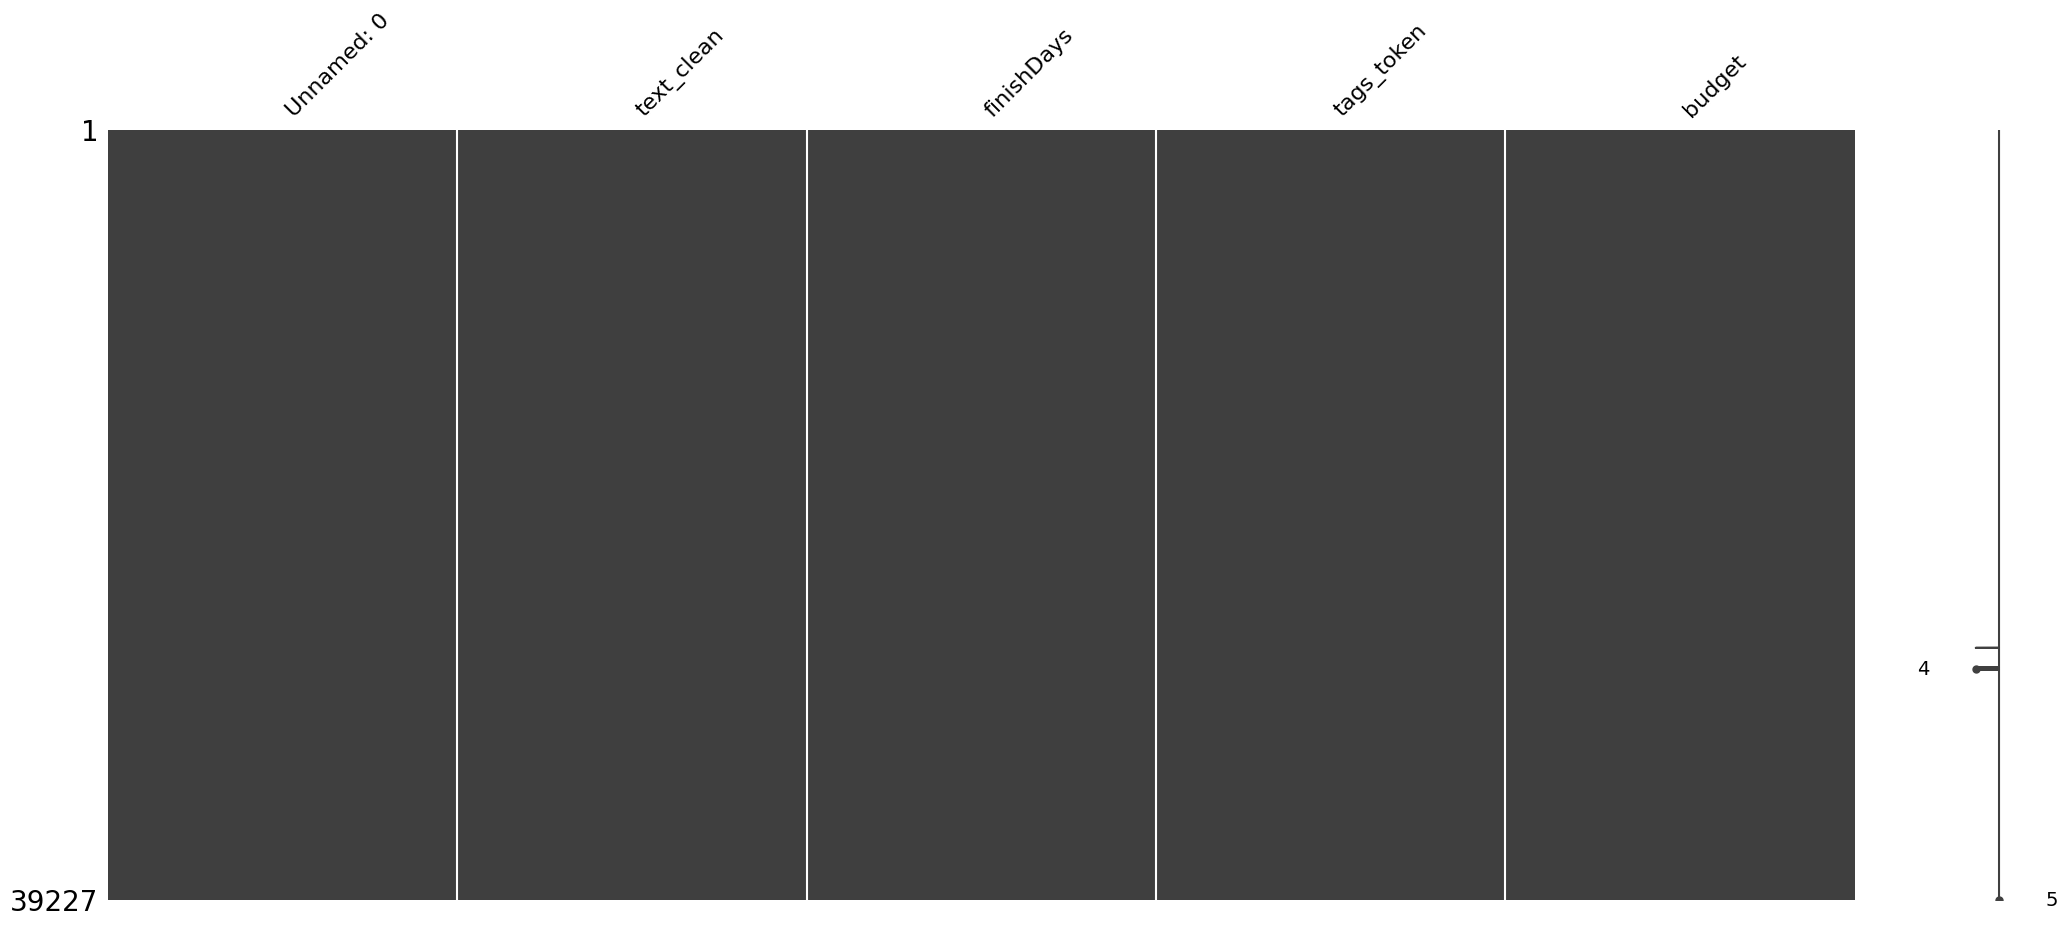

In [ ]:
msno.matrix(projects)
plt.show()

In [ ]:
round(projects.isna().mean().sort_values(ascending = False), 4)

text_clean    0.0001
Unnamed: 0    0.0000
finishDays    0.0000
tags_token    0.0000
budget        0.0000
dtype: float64

### **Target Overview**

##### `budget`

In [ ]:
df = projects

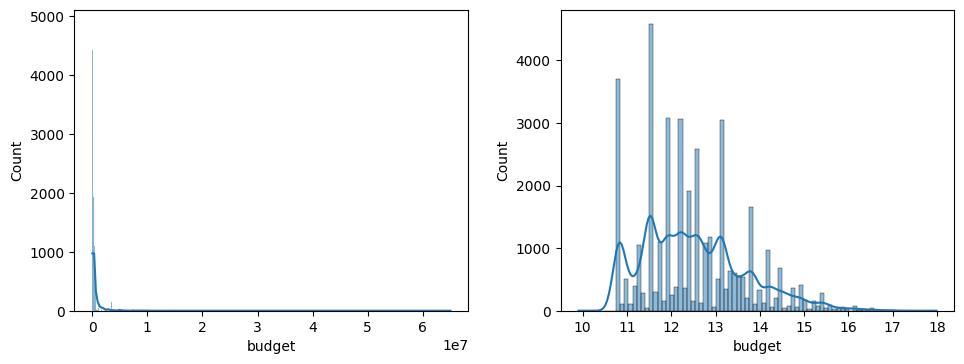

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(df['budget'], kde = True, ax = axes[0])
sns.histplot(np.log(df['budget']), kde = True, ax = axes[1])

plt.tight_layout(pad = 2)
plt.show()

## Pre-modeling

In [ ]:
df['text'] = df['text_clean'].astype(str)

In [ ]:
BINS = [20000,50000,100000,150000,200000,250000,300000,400000,450000,500000,
        600000, 700000, 800000, 900000, 1000000,
        1500000, 2000000, 2500000, 3000000, 4000000, 5000000, 6000000, 7000000, 
        8000000, 9000000, 10000000, 15000000, 20000000, 25000000, 30000000, 40000000]

df['budget_bins'] = pd.cut(x=df['budget'], bins=BINS, labels=False)

In [ ]:
df = df[df['budget'] < 25000000]

In [ ]:
df['budget_tags'] = np.select(
    [df['budget'].between(20000, 50000),
     df['budget'].between(50000, 100000),
     df['budget'].between(100000, 150000),
     df['budget'].between(150000, 200000),
     df['budget'].between(200000, 250000),
     df['budget'].between(250000, 300000),
     df['budget'].between(300000, 350000),
     df['budget'].between(350000, 450000),
     df['budget'].between(450000, 500000),
     df['budget'].between(500000, 600000),
     df['budget'].between(600000, 700000),
     df['budget'].between(700000, 800000),
     df['budget'].between(800000, 900000),
     df['budget'].between(900000, 1000000),
     df['budget'].between(1000000, 1250000),
     df['budget'].between(1250000, 1500000),
     df['budget'].between(1500000, 1750000),
     df['budget'].between(1750000, 2000000),
     df['budget'].between(2000000, 2500000),
     df['budget'].between(2500000, 3000000),
     df['budget'].between(3000000, 4000000),
     df['budget'].between(4000000, 5000000),
     df['budget'].between(5000000, 6000000),
     df['budget'].between(6000000, 7000000),
     df['budget'].between(7000000, 8000000),
     df['budget'].between(8000000, 9000000),
     df['budget'].between(9000000, 10000000),
     df['budget'].between(10000000, 12500000),
     df['budget'].between(12500000, 15000000),
     df['budget'].between(15000000, 17500000),
     df['budget'].between(17500000, 20000000),
     df['budget'].between(20000000, 25000000)],
    ['20 - 50 Ribu', '50 - 100 Ribu', '100 - 150 Ribu', '150 - 200 Ribu','200 - 250 Ribu',
     '250 - 300 Ribu', '300 - 350 Ribu', '350 - 450 Ribu','450 - 500 Ribu', '500 - 600 Ribu',
     '600 - 700 Ribu', '700 - 800 Ribu', '800 - 900 Ribu', 
     '900 Ribu -  1 Juta', '1 -  1.25 Juta', '1.25 -  1.5 Juta', '1.5 -  1.75 Juta', '1.75 -  2 Juta', 
     '2 -  2.5 Juta', '2.5 -  3 Juta', '3 -  4 Juta', '4 -  5 Juta', '5 -  6 Juta', '6 -  7 Juta',
     '7 -  8 Juta', '8 -  9 Juta', '9 -  10 Juta', '10 -  12.5 Juta', '12.5 -  15 Juta',
     '15 -  17.5 Juta', '17.5 -  20 Juta', '20 -  25 Juta'],
    np.nan
)

In [ ]:
df.head()

,Unnamed: 0,text_clean,finishDays,tags_token,budget,text,budget_bins,budget_tags
0,0,penulis tinggal apartemen jakarta menulis 1 ar...,7.0,['Writing'],250000.0,penulis tinggal apartemen jakarta menulis 1 ar...,4.0,200 - 250 Ribu
1,1,membuat artikel media online pekerjaan membuat...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0,membuat artikel media online pekerjaan membuat...,6.0,300 - 350 Ribu
2,2,editing 12 shortt video konten tiktok hi ada 1...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0,editing 12 shortt video konten tiktok hi ada 1...,3.0,150 - 200 Ribu
3,3,cari akun canva creator element template punya...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0,cari akun canva creator element template punya...,13.0,900 Ribu - 1 Juta
4,4,cari jasa upload aplikasi app store sedang men...,7.0,['iPhone/iOS'],150000.0,cari jasa upload aplikasi app store sedang men...,2.0,100 - 150 Ribu


In [ ]:
# Filtering the rare terms.
df_filtered = df.groupby("budget_tags").filter(lambda x: len(x) > 1)
df_filtered['budget_tags'] = df_filtered['budget_tags'].apply(lambda x: f"'{x}'")
df_filtered['budget_tags'] = df_filtered['budget_tags'].apply(lambda x: f'[{x}]')
df_filtered['budget_tags'] = list(df_filtered['budget_tags'].astype(str))

In [ ]:
df_filtered['budget_tags'].head()

0        ['200 - 250 Ribu']
1        ['300 - 350 Ribu']
2        ['150 - 200 Ribu']
3    ['900 Ribu -  1 Juta']
4        ['100 - 150 Ribu']
Name: budget_tags, dtype: object

In [ ]:
import ast 

df_filtered['budget_tags'] = [ast.literal_eval(i) for i in df_filtered['budget_tags']]
df_filtered['budget_tags'].values[:5]

array([list(['200 - 250 Ribu']), list(['300 - 350 Ribu']),
       list(['150 - 200 Ribu']), list(['900 Ribu -  1 Juta']),
       list(['100 - 150 Ribu'])], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["budget_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 35293
Number of rows in validation set: 1961
Number of rows in test set: 1961


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
terms = tf.ragged.constant(train_df["budget_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', '50 - 100 Ribu', '100 - 150 Ribu', '150 - 200 Ribu', '20 - 50 Ribu', '450 - 500 Ribu', '250 - 300 Ribu', '200 - 250 Ribu', '350 - 450 Ribu', '900 Ribu -  1 Juta', '300 - 350 Ribu', '1.25 -  1.5 Juta', '500 - 600 Ribu', '700 - 800 Ribu', '1.75 -  2 Juta', '600 - 700 Ribu', '2 -  2.5 Juta', '2.5 -  3 Juta', '1 -  1.25 Juta', '4 -  5 Juta', '3 -  4 Juta', '800 - 900 Ribu', '1.5 -  1.75 Juta', '5 -  6 Juta', '9 -  10 Juta', '6 -  7 Juta', '7 -  8 Juta', '12.5 -  15 Juta', '10 -  12.5 Juta', '8 -  9 Juta', '17.5 -  20 Juta', '15 -  17.5 Juta', '20 -  25 Juta']


In [ ]:
sample_label = train_df["budget_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['200 - 250 Ribu']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["budget_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Budget: {invert_multi_hot(label[0])}")
    print(" ")

Text: b'cari jasa mendownload foto menuliskan copywriting produk website hai kelvin owner online shop sedang mencariteam work dapat bekerja freelance tugasnya mendownload foto marketplace website rangkum menjadi sebuah file maksutnya ini misal link tokopedia sebuah produk link atas ketahui produk tas masukan sebuah file excel software pendukung mudah di baca mudah di input nantinya ke website'
Budget: ['50 - 100 Ribu']
 
Text: b'membuat crud formulir pendaftaran dear all worker memiliki sebuah form pendaftaran form mendaftar tambah yang tinggal form edit formulir view formulirnya menggunakan codeigniter project mudah lama pengerjaan 1 2 hari selesai melebihi batas waktu saya berhak melakukan arbitrase worker bid terbaik portfolio cukup terpilih kasih'
Budget: ['150 - 200 Ribu']
 
Text: b'pembuatan artikel dibutuhkan pembuat artikel tema fashion lifestyle projek jangka panjang bila sesuai harapan ini dibutuhkan 2 artikel awal'
Budget: ['100 - 150 Ribu']
 
Text: b'dicati jasa setting tam

In [ ]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

48962


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

## Base Model

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(216, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
276/276 [==============================] - 12s 23ms/step - loss: 0.1256 - binary_accuracy: 0.9669 - val_loss: 0.1037 - val_binary_accuracy: 0.9707
Epoch 2/20
276/276 [==============================] - 7s 25ms/step - loss: 0.0646 - binary_accuracy: 0.9768 - val_loss: 0.1176 - val_binary_accuracy: 0.9688
Epoch 3/20
276/276 [==============================] - 7s 24ms/step - loss: 0.0275 - binary_accuracy: 0.9912 - val_loss: 0.1529 - val_binary_accuracy: 0.9678
Epoch 4/20
276/276 [==============================] - 7s 24ms/step - loss: 0.0164 - binary_accuracy: 0.9951 - val_loss: 0.1920 - val_binary_accuracy: 0.9661
Epoch 5/20
276/276 [==============================] - 6s 20ms/step - loss: 0.0127 - binary_accuracy: 0.9962 - val_loss: 0.2119 - val_binary_accuracy: 0.9652
Epoch 6/20
276/276 [==============================] - 7s 24ms/step - loss: 0.0109 - binary_accuracy: 0.9966 - val_loss: 0.2306 - val_binary_accuracy: 0.9641
Epoch 7/20
276/276 [==============================] - 6s 

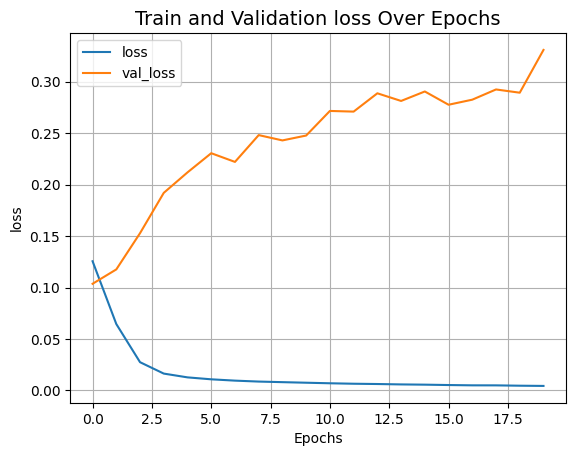

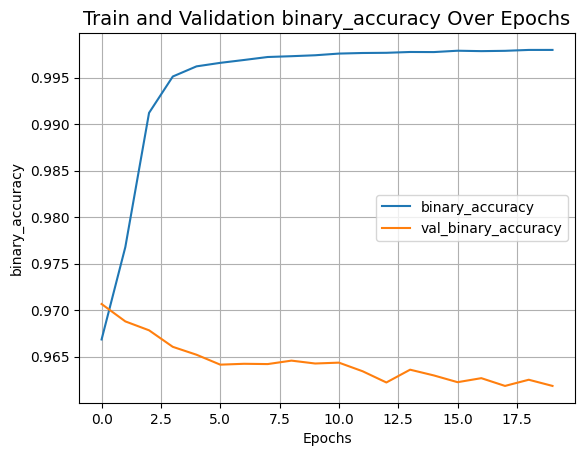

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [ ]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

16/16 [==============================] - 0s 15ms/step - loss: 0.3534 - binary_accuracy: 0.9603
Categorical accuracy on the test set: 96.03%.


In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Budget: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_1_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    print(f"Predicted Budget: ({', '.join([label for label in top_1_labels])})")
    print(" ")

4/4 [==============================] - 0s 6ms/step
Text: b'php admin adminlte show data push notif telegram api post ulang dapat kandidat sesuai butuh programmer buat dashboard admin menggunakan adminlte template lain buat show data database saya siapkan setiap data baru masuk db di push notifikasi telegram database mysql saya siapkan tinggal show di halaman admin bisa menggunakan datatables dan pagin ada proses crud'
Budget: ['250 - 300 Ribu']
Predicted Budget: (450 - 500 Ribu)
 
Text: b'design brosur a5 custom sport jersey perlu bantuan design brosur uk a5 promosi jasa pembuatan custom sport jersey budget rp 500 000 dateline 2 hari berikan link portfolio design teman-teman website facebook instagram materi saya logo beberapa mockup file png sisanya desainer thanks'
Budget: ['250 - 300 Ribu']
Predicted Budget: (150 - 200 Ribu)
 
Text: b'penulis blog bahasa inggris membutuhkan mampu menulis artikel bahasa inggris baik adapun syarat harus dipenuhi sebagai jumlah kata min 800 kata jumlah